In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import cnames
from matplotlib import animation, rc


# Sprott's "Algebraically simplest dissipative chaotic flow"

From an equation for the "jerk" (time-derivative of the acceleration) of a particle 

$$
\dddot{x} + a\ddot{x} - \dot{x}^2 + x = 0, \quad 2.0168 < a < 2.0577
$$

Defining $y = \dot{x}$ and $z = \ddot{x} = \dot{y}$, this can be written

$$
\begin{align*}
\dot{x} &= y\\
\dot{y} &= z \\
\dot{z} &= -x + y^2 - az
\end{align*}
$$

Supposedly, the attractor for this system is a Mobius strip! Let's see.

[https://pdf.sciencedirectassets.com/271541/1-s2.0-S0375960100X01181/1-s2.0-S0375960197000881/main.pdf]

In [2]:
def sprott(t, Y, a):
    x, y, z = Y  
    return [y, z, -x +y*y -a*z]  


In [3]:
solver = ode(sprott)
solver.set_integrator('dop853') # dopri5')   
#solver.set_integrator('dop853') #,atol=1e-14,rtol=1e-8,nsteps=500,dfactor=.05)

#atol : float or sequence absolute tolerance for solution
#rtol : float or sequence relative tolerance for solution
#nsteps : int Maximum number of (internally defined) steps allowed during one call to the solver.
#first_step : float
#max_step : float
#safety : float Safety factor on new step selection (default 0.9)
#ifactor : float
#dfactor : float Maximum factor to increase/decrease step size by in one step
#beta : float Beta parameter for stabilised step size control.
#verbosity : int Switch for printing messages (< 0 for no messages).

print('atol:', solver._integrator.atol)
print('rtol:', solver._integrator.rtol)
print('nsteps:', solver._integrator.nsteps)
print('first_step:', solver._integrator.first_step)
print('max_step:', solver._integrator.max_step)
print('safety:', solver._integrator.safety)
print('ifactor:', solver._integrator.ifactor)
print('dfactor:', solver._integrator.dfactor)
print('beta:', solver._integrator.beta)


atol: 1e-12
rtol: 1e-06
nsteps: 500
first_step: 0.0
max_step: 0.0
safety: 0.9
ifactor: 6.0
dfactor: 0.3
beta: 0.0


In [4]:
def runsprott(Y0, t, a):

    Y = np.empty((len(t), 3))
    Y[0] = Y0
    solver = ode(sprott)
    solver.set_f_params(a)
    solver.set_initial_value(Y[0], 0.)

    k = 1
    while solver.successful() and solver.t < t[-1]:
        solver.integrate(t[k])
        Y[k] = solver.y
        k += 1

    return Y


In [5]:
a = 2.03
Y0 = [.05, .05, .05]  # initial vector X0 = [x(0), y(0), z(0)]
T = 1000.0

t = np.linspace(0.0, T, int(T*10))

Y = runsprott(Y0, t, a) 

In [8]:
Y.shape

(10000, 3)

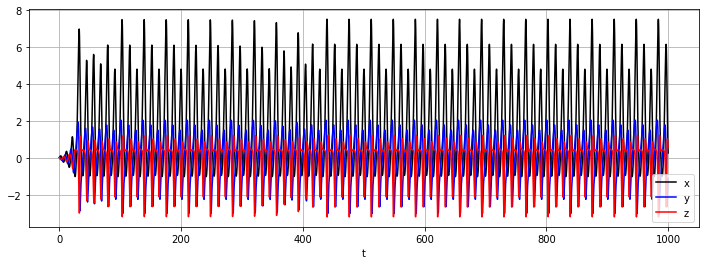

In [6]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(t, Y[:,0],'k')
ax.plot(t, Y[:,1],'b')
ax.plot(t, Y[:,2],'r')
ax.grid(True)
ax.set(xlabel='t')
ax.legend(['x','y','z'],loc="lower right")


[Text(0.5, 0, 'z'), Text(0.5, 0, 'y'), Text(0.5, 0, 'x')]

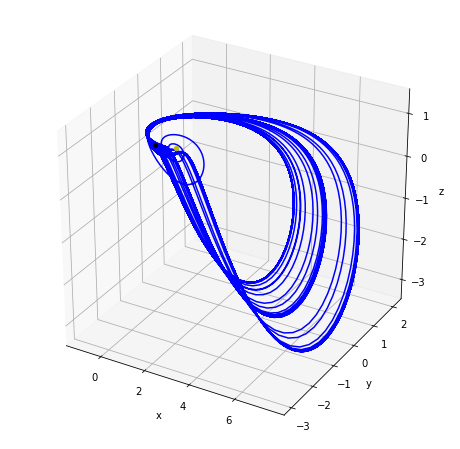

In [7]:
fig = plt.figure(figsize=(8,8))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(111,projection='3d')
ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], 'b')
ax.scatter(Y[0, 0],Y[0, 1], Y[0, 2] , c='y')     # make a yellow dot at the start
ax.scatter(Y[-1,0], Y[-1,1], Y[-1,2] , c='k')     # make a black dot at the end
ax.set(xlabel='x', ylabel='y', zlabel='z')

In [17]:
N_trajectories = 20

# Choose random starting points, uniformly distributed from -3 to 3
np.random.seed(1)
Y0 = -3 + 6 * np.random.random((N_trajectories, 3))

T = 400.0
t = np.linspace(0.0, T, int(T*10))

Yv = np.asarray([runsprott(Y0i, t, a) for Y0i in Y0])


In [ ]:
# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

# set up lines and points
lines = [ax.plot([], [], [], '-', c=c)[0]
            for c in colors]
pts = [ax.plot([], [], [], 'o', c=c)[0]
            for c in colors]

# prepare the axes limits
ax.set_xlim((-2, 8))
ax.set_ylim((-3, 3))
ax.set_zlim((-4, 2))

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(30, 0)

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        line.set_data([], [])
        line.set_3d_properties([])

        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    #i = (2 * i) % x_t.shape[1]
    i = (2 * i) % Y.shape[0]

    for line, pt, Yi in zip(lines, pts, Yv):
        x, y, z = Yi[:i].T
        line.set_data(x, y)
        line.set_3d_properties(z)

        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=5000, interval=30) #, blit=True)

rc('animation', html='html5')
anim

# Save as mp4. This requires mplayer or ffmpeg to be installed
#anim.save('sprott_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])